# CGM prediction tests #
Michael Strand / Chelsea Huynh


## Considerations: ##
    - Choosing predicting features: We need 5 minutes worth of readings to predict 1 glucose measure. If there are m glucose measures then we must be careful that #features * 5 * (measure frequency) < m, otherwise the system is overdetermined.

In [1]:
import random

def ltuple_msgd(A_tilde, y, maxiter, p, ell, alpha): 

    m = np.shape(A_tilde)[0]
    n = np.shape(A_tilde)[1]
    resid_err = np.zeros((maxiter))
    xhat = np.zeros((n, 1))
    current_iter = 0
    approx_err = np.zeros((1, maxiter))
    
    # Create Matrix Q for the update function
    L_matrix = np.zeros((n,n))
    for i in range(0, n - (n % ell), ell):
        v = np.zeros((n))
        v[i:i + ell] = 1
        L_matrix = L_matrix + (np.outer(v,v))

    while current_iter < maxiter:
        
        i = random.randint(0,m-1)
        Ai_tilde = A_tilde[i,:]
        
        # split these since numpy is weird with matrix mults and we don't want any mistakes
        At = np.transpose(Ai_tilde)
        A1 = np.dot(Ai_tilde, xhat) - p*y[i]
        AA = (A1*At).reshape((n,1))
        BB = np.multiply(L_matrix, np.outer(Ai_tilde, Ai_tilde))
        CC = np.dot(BB, xhat)
        
        gxk = (1/p**2)*AA - ((1-p)/p**2)*CC
        xhat -= alpha*gxk
        
        y_e = np.linalg.norm(np.dot(A_tilde, xhat) - y)**2
        resid_err[current_iter] = y_e
        
        current_iter += 1
            
    return resid_err

In [2]:
import random

# sgd to test on unmasked analogs

def sgd(A_tilde, y, maxiter, alpha): 

    m = np.shape(A_tilde)[0]
    n = np.shape(A_tilde)[1]
    resid_err = np.zeros((maxiter))
    xhat = np.zeros((n, 1))
    current_iter = 0
    approx_err = np.zeros((1, maxiter))

    while current_iter < maxiter:
        
        i = random.randint(0,m-1)
        Ai_tilde = A_tilde[i,:]
        
        # split these since numpy is weird with matrix mults and we don't want any mistakes
        At = np.transpose(Ai_tilde)
        A1 = np.dot(Ai_tilde, xhat) - y[i]
        AA = (A1*At).reshape((n,1))
        
        gxk = AA
        xhat -= alpha*gxk
        
        y_e = np.linalg.norm(np.dot(A_tilde, xhat) - y)**2
        resid_err[current_iter] = y_e
        
        current_iter += 1
            
    return resid_err

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cleans and preps patient 1 day 2 data (trimming & organizing)

# breathing table

raw_breathing = pd.read_csv('2014_10_02-10_56_44_Breathing.csv')
raw_breathing['Time'] = raw_breathing['Time'].str[10:]
raw_breathing_slim = raw_breathing.loc[(raw_breathing['Time']).str[-3:] == '420']
raw_breathing_slim['Time'] = raw_breathing_slim['Time'].str[:9]

# ecg table

raw_ecg = pd.read_csv('2014_10_02-10_56_44_ECG.csv')
raw_ecg['Time'] = raw_ecg['Time'].str[10:]
raw_ecg_slim = raw_ecg.loc[(raw_ecg['Time']).str[-3:] == '424']
raw_ecg_slim['Time'] = raw_ecg_slim['Time'].str[:9]

# trim glucose measures so we can properly shape our A matrix 

raw_glucose = pd.read_csv('glucose.csv')
raw_glucose_day1 = raw_glucose.loc[(raw_glucose['date']).str[-1] == '2']
raw_glucose_day1 = raw_glucose_day1.drop('comments', axis=1)

# start at 10:56
raw_glucose_day1_trim = raw_glucose_day1.iloc[135:-30]
raw_glucose_day1_trim['time'] = raw_glucose_day1_trim['time'].str[:5]

# drop manual imputations for conistancy 
raw_glucose_day1_trim = raw_glucose_day1_trim.loc[(raw_glucose_day1_trim['type']) == 'cgm']

# Concate floating tables with summary table 
raw_summary = pd.read_csv('2014_10_02-10_56_44_Summary.csv')
raw_summary = raw_summary.iloc[436:-424] # trim measurements that don't correspond to a prediction (5 minute interval)
raw_summary['Time'] = raw_summary['Time'].str[10:]
raw_summary['Time'] = raw_summary['Time'].str[:9]

noise = raw_summary[['ECGNoise']]

# junk variables (all constant)
raw_summary = raw_summary.drop('BRNoise', axis=1)
raw_summary = raw_summary.drop('BRConfidence', axis=1)
raw_summary = raw_summary.drop('GSR', axis=1)
raw_summary = raw_summary.drop('LinkQuality', axis=1)
raw_summary = raw_summary.drop('RSSI', axis=1)
raw_summary = raw_summary.drop('TxPower', axis=1)
raw_summary = raw_summary.drop('ECGNoise', axis=1)

# HR != 0 in a living human
raw_summary['HR'] = raw_summary['HR'].mask(raw_summary['HR'] == 0).ffill()

C:\Users\mikew\AppData\Local\Temp/ipykernel_3264/3163058902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_breathing_slim['Time'] = raw_breathing_slim['Time'].str[:9]
C:\Users\mikew\AppData\Local\Temp/ipykernel_3264/3163058902.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_ecg_slim['Time'] = raw_ecg_slim['Time'].str[:9]
C:\Users\mikew\AppData\Local\Temp/ipykernel_3264/3163058902.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [7]:
from sklearn.preprocessing import StandardScaler
# function to do everything


def cgm_preds(raw_data, glucose_readings, noise, features: list, eta : int, maxiter, too_high_noise : float):
    
    qualities_norm = raw_data.copy()
    y_glucose = pd.DataFrame(glucose_readings).to_numpy().reshape(-1,1)
    qualities_norm = qualities_norm[features] # separate out desired features
    
    # standardize
    scaler = StandardScaler(copy = True)
    qualities_norm = scaler.fit_transform(qualities_norm)
    y_glucose_norm = scaler.fit_transform(y_glucose)
    
    glucose_measure_counts = len(glucose_readings)
    feature_count = len(features)
    m = glucose_measure_counts

    # take data in specified intervals (eta)
    qualities_norm = pd.DataFrame(qualities_norm).iloc[::60//eta, :] # choose every 60/eta'th row 
   
    # reshape (glucose readings x 5 * features * frequency = m x n)
    A_norm = np.reshape(qualities_norm.to_numpy(), (-1)) # flatten
    A_norm = np.reshape(A_norm, (m,-1)) # reshape - each row corresponds to 5*60 seconds (in eta intervals) of readings
    
    # masking by noise
    n = A_norm.shape[1]
    mask = np.ones((m,n))
    noise_vec = noise.to_numpy()
    A_norm_mask = A_norm.copy()

    index = 0
    zeros = 0

    # generate mask
    for i in range(m):
        for j in range(n//feature_count):
            if noise_vec[index] > too_high_noise:

                zeros += feature_count
                A_norm_mask[i, feature_count*j:feature_count*(j+1)] = 0

            index += 1
            
    p = 1 - zeros/(m*n) # estimate for probability data present
    ell = feature_count # tuple size = number of features per reading

    print('p:', p)
    print('dimension:', A_norm.shape)
    print('features:', feature_count)

    fig, axes = plt.subplots(2, 3, figsize=(13, 7))
    fig.tight_layout(pad = 5)

    for i in range(8):
        alpha = 10**(-(0.5*i + 2))

        lerr = ltuple_msgd(A_norm_mask, y_glucose_norm, maxiter, p, ell, alpha)
        err = sgd(A_norm, y_glucose_norm, maxiter, alpha)
        plt.subplot(2, 4, i+1)
        plt.plot(lerr, label = 'ltuple mSGD')
        plt.plot(err, label = 'SGD') 
        plt.title("{0:.7f}".format(alpha), loc = 'right')

    plt.legend(['ltuple mSGD - masked', 'SGD - unmasked'], loc = 'lower left')    
    plt.show()
    
    return None

p: 0.8888888888888888
dimension: (126, 15)
features: 3


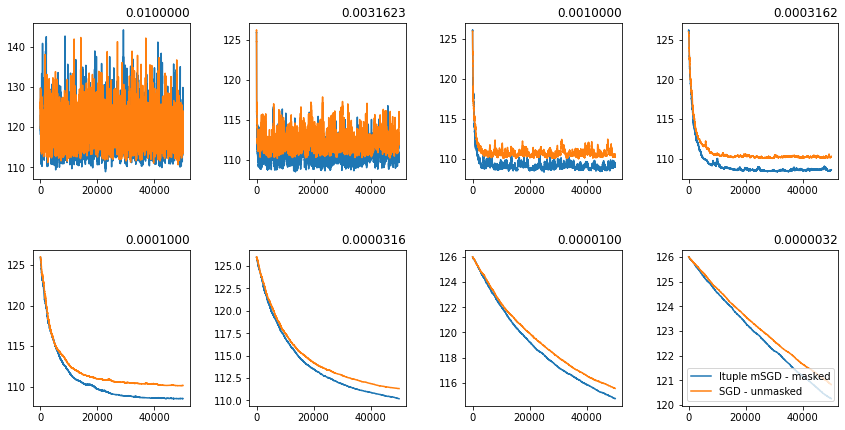

In [11]:
qualities = pd.concat([raw_summary.set_index('Time'), 
                       raw_breathing_slim.set_index('Time'), 
                       raw_ecg_slim.set_index('Time')],
                axis=1, join='inner') # note the inner join forces ecg/breathing tables to have the same trimmed times

features = ['HR', 'EcgWaveform', 'ECGAmplitude']
eta = 1
too_high_noise = 0.00085
maxiter = 50000
cgm_preds(qualities, raw_glucose_day1_trim['glucose'], features = features, noise = noise, eta = eta, too_high_noise = too_high_noise, maxiter = maxiter)